# Detector of Racial Bias based on Population Simulation System

## Disclaimer



This is the first draft and does not reflect the final version of the project. 

## Acknowledgement

I'd like to thank Professor Abolfazl Asudeh personally for his support with direction, early idea formulation, and insightful advice that considerably improved the quality of this project.

## Introduction

The primary goal of this project is to assess the bias of the Divvy system based on geography and accessibility by simulating the population of that location and evaluating whether the system is racially and/or gender biased. The goal is to uncover and expose any potential bias using statistical data.

## Research Direction

We would apply the normal procedure to research the issue of Racial Bias. As a result, we would focus on the three main aspects:
1. Data Modeling: We would focus on determining the kind of population data, its source, and its dependability. Furthermore, we would focus on how we would manage and organise statistical population data for the models.
2. Population simulation: we'll try to figure out how we'd choose a participant at random from the population's data. We would specifically focus on a person's race, gender, and location as randomized data.
3. Method of Examination: For each geological input, we would examine its bias in respect to the simulated population. As a result, we will focus on the bias algorithm. Furthermore, we would give a user-friendly interface for users to observe how each simulated human is approaching the place using the supplied data.

## Data Modeling


We would use the data from the two sources: Census Bureau, Federal Communication Commission


### Federal Communication Commission 

With a specific geographic coordinate (including the indormation about the latitude and the longitude), we would need an API to retrieve the FIPS code to feed into the data to the `getDeccennial()` function above. 

In [ ]:
import requests
def getFIPS(lat, long, year = 2020, division = "Block"):
    if division not in {"Block", "County", "State"}:
        raise Exception("The administration division level is not correct")
    try:
        url = "https://geo.fcc.gov/api/census/block/find?latitude=" + \
            str(lat)+"&longitude="+str(long) + "&censusYear=" + \
            str(year)+"&showall=false&format=json"
        response = requests.get(url)
        print(response.text)
        return response.json()[division]["FIPS"]

    except requests.ConnectionError as error:
        print("Cannot connect to the GEO API")
        print(error)


In [ ]:
getFIPS(41.886269657542044, -87.70033108160133, year = 2020)

{"Block":{"FIPS":"170318371002011","bbox":[-87.701359,41.885909,-87.69888,41.886508]},"County":{"FIPS":"17031","name":"Cook County"},"State":{"FIPS":"17","code":"IL","name":"Illinois"},"status":"OK","executionTime":"0"}


'170318371002011'

### Census Bureau Data

We will use the Deccenial Census of Population and Housing Data. In default, we would use the data in year 2020. Furthermore, we would based on the Federal Information Processing Standards (FIPS) to retrieve the data. More information on the data could be found over [here](https://www.census.gov/data/developers/data-sets/decennial-census.html).

Due to the project would concern especially with the racial information, we would retrieve all the data in group P1.

In [ ]:
from numpy.core.shape_base import block
import requests
import pandas as pd
import numpy as np
    
def getDecennialData(fips, for_unit = 'block', dataField = "group(P1)", year = "2020"):
    if (for_unit not in {'state', 'county', 'tract', 'block'}):
        assert("for_unit must be 'state', 'county', 'tract', or 'block' ")
    if len(fips) < 2 :
        assert("FIPS must have length greater than 2")
    
    list_string = ['state:'+ fips[0:2],
                   'county:'+ (fips[2:5] if len(fips) >= 5 else '*'), 
                   'tract:' + (fips[5:11] if len(fips) >= 11 else '*'), 
                   'block:' + (fips[11:15] if len(fips) == 15 else '*')]
    
    while list_string[-1].find(for_unit) == -1 :
        list_string.pop()
    for_unit_string = list_string.pop()
    
    url = "https://api.census.gov/data/"+ year +"/dec/pl?get="+ dataField + \
          "&for="+ for_unit_string + ("&in=" if len(list_string) > 0 else "") + \
          "%20".join(list_string)

    try:
        response = requests.get(url)
        JSONObject = response.json()
        if len(JSONObject)  == 2:
            series = pd.Series(JSONObject[1], index=JSONObject[0]).dropna()
            return series
        else:
            dataframe = pd.DataFrame(data= JSONObject[1:], columns=JSONObject[0])
            dataframe.sort_values(by=["GEO_ID"], inplace=True, ignore_index=True)
            return dataframe
            
    except requests.ConnectionError as error:
        print("Cannot connect to the Census API")
        print(error)


def getDecennialDescription():
    try:
        url = "https://api.census.gov/data/2020/dec/pl/variables"
        response = requests.get(url)
        JSONObject = np.array(response.json())
        series = pd.Series(JSONObject[:, 1], index=JSONObject[:, 0])
        series.loc["state"] = "State FIPS"
        series.loc["county"] = "County FIPS"
        series.loc["tract"] = "Tract FIPS"
        series.loc["block"] = "Block FIPS"
        series.loc["NAME"] = "NAME"
        series = series.map(lambda label: label.split("!!")[-1])
        return series

    except requests.ConnectionError as error:
        print("Cannot connect to the Census API")
        print(error)



In [ ]:
description_dict = getDecennialDescription()
description_dict

name                                            label
for                      Census API FIPS 'for' clause
in                        Census API FIPS 'in' clause
ucgid      Uniform Census Geography Identifier clause
P4_003N                       Not Hispanic or Latino:
                              ...                    
state                                      State FIPS
county                                    County FIPS
tract                                      Tract FIPS
block                                      Block FIPS
NAME                                             NAME
Length: 344, dtype: object

For instance, we would want to retrieve the Racial data at East Campus of UIC which has the FIPS of `170318419002012`, we would run the function

In [ ]:
getDecennialData("170318419002012")

GEO_ID                              1000000US170318419002012
NAME       Block 2012, Block Group 2, Census Tract 8419, ...
P1_001N                                                    0
P1_002N                                                    0
P1_003N                                                    0
                                 ...                        
P1_071N                                                    0
state                                                     17
county                                                   031
tract                                                 841900
block                                                   2012
Length: 77, dtype: object

Similarly, we would want to retrieve the tract data the has the same county FIPS of `17031`, we would run the function

In [ ]:
getDecennialData("17031", for_unit='tract')

,GEO_ID,NAME,P1_001N,P1_001NA,P1_002N,P1_002NA,P1_003N,P1_003NA,P1_004N,P1_004NA,...,P1_068NA,P1_069N,P1_069NA,P1_070N,P1_070NA,P1_071N,P1_071NA,state,county,tract
0,1400000US17031010100,"Census Tract 101, Cook County, Illinois",4905,None,4411,None,1652,None,2187,None,...,None,0,None,0,None,0,None,17,031,010100
1,1400000US17031010201,"Census Tract 102.01, Cook County, Illinois",6939,None,6141,None,1832,None,2574,None,...,None,0,None,0,None,0,None,17,031,010201
2,1400000US17031010202,"Census Tract 102.02, Cook County, Illinois",2742,None,2425,None,1078,None,767,None,...,None,0,None,0,None,0,None,17,031,010202
3,1400000US17031010300,"Census Tract 103, Cook County, Illinois",6305,None,5511,None,2963,None,1778,None,...,None,0,None,0,None,0,None,17,031,010300
4,1400000US17031010400,"Census Tract 104, Cook County, Illinois",5079,None,4675,None,3148,None,620,None,...,None,0,None,0,None,0,None,17,031,010400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,1400000US17031844600,"Census Tract 8446, Cook County, Illinois",1776,None,1736,None,55,None,1647,None,...,None,0,None,0,None,0,None,17,031,844600
1328,1400000US17031844700,"Census Tract 8447, Cook County, Illinois",2342,None,2196,None,143,None,1821,None,...,None,0,None,0,None,0,None,17,031,844700
1329,1400000US17031980000,"Census Tract 9800, Cook County, Illinois",0,None,0,None,0,None,0,None,...,None,0,None,0,None,0,None,17,031,980000
1330,1400000US17031980100,"Census Tract 9801, Cook County, Illinois",18,None,14,None,6,None,3,None,...,None,0,None,0,None,0,None,17,031,980100


## Principles of data simulation
We'd mimic the data using the Geographic Hierachy shown below. However, in the figure below, we would just concentrate on the State level down to the Block level.
This includes the following:

1. State

2. Counties

3. Block Groups

4. Census Blocks


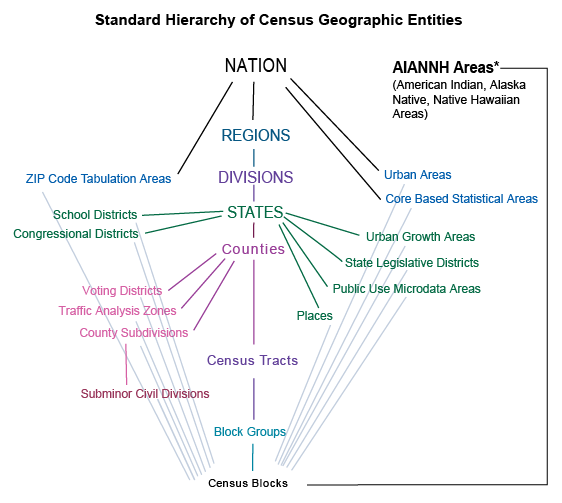

## Design Pattern for data retrieval
In order to give the best efficiency in data retrieval, we must create a way to minimize the total data API requests and maximize the reuse of the data. Therefore, we decided to use:
1. Singleton Design Pattern: The singleton design pattern limits a class's instantiation to a single instance. This is done to enable coordinated access to a certain resource throughout an entire software system. The singleton class uses this design pattern to guarantee that it is only created once and may enable simple access to the one instance. We'd utilize this to reduce the number of Block instantiations required for various randomized functions in State classes that use Block data and operations.
2. Component Design Pattern: The composite pattern is a partitioning design pattern that specifies a set of items that are processed as if they were a single instance of the same kind of object. A composite's goal is to "compose" things into tree structures that depict part-whole hierarchies. It enables you to create a tree structure and assign tasks to each node in the tree structure. We would use this in the need of evoke smaller operations from the bigger classes. For instance, we would want to access a `Block` operation from the `State` level.
3. Template Method: An abstract class provides specified methods (templates) for executing its methods. Its subclasses may alter the method implementation as needed, but invocation must follow the rules provided by an abstract class. This pattern falls under the area of behavioural patterns. We would use this strategy to develop a number of classes that all perform the same purpose. A 'Block,' for example, may be formed by performing an API call or obtaining a data record from the State. As a result, we'd have `BlockByAPI` and `BlockByState`, which are essentially the same thing but different in how the data is retrieved.


## Person
This is the profile for a person in the simulation. It will contains:
1. Person's current block
2. The race of that person
3. The location of that person based on the block

In [ ]:
class Person():
    def __init__(self, blockFIPS, race):
        self._blockFIPS = blockFIPS
        self._race = race
        self._location = None

    @property
    def blockFIPS(self):
        return self._blockFIPS
    
    @property
    def race(self):
        return self._race

    @property
    def location(self):
        if (self._location is None):
          # "INTPTLAT, INTPTLON" // still working on this
            print(getDecennialData(self._blockFIPS, dataField = "TRISUBREM"))
        return self._location

    @location.setter
    def censusYear(self, location):
      self._location = location

    def __repr__(self):
      return f"<Person block_FIPS:{self._blockFIPS}, race:{self._race}>"

For instance, here is an example person:

In [ ]:
newPerson = Person("170318371002011", "P1_003N")
newPerson

<Person block_FIPS:170318371002011, race:P1_003N>

## Plotting function
This function helps plotting a sample


In [ ]:
def plotSample(sample):
    sample = pd.Series([person.race for person in sample]).value_counts().sort_index()
    labels = list(map(lambda x : description_dict[x], sample.index))
    print(labels)
    print(sample.tolist())
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_axes([0,0,1,1])

    ax.set_title('Sample by race of ' + str(sum(sample))+ " people")
    ax.set_xlabel("Race")
    ax.set_ylabel("Number of People")
    plt.xticks(rotation="vertical")
    ax.bar(labels, sample.tolist())
    plt.show()

## Unit

Each State, each Block, each County, each Tract is an administrative unit. Therefore, we can build an abstract administrative unit class as follows:

In [ ]:
from abc import ABC, abstractmethod

class UnitInterface(ABC):
    def __init__(self):
        pass

    @property
    @abstractmethod
    def FIPS(self):
      pass

    @property
    @abstractmethod
    def censusYear(self):
      pass
    
    @property
    @abstractmethod
    def decennialData(self):
      pass

    @property
    @abstractmethod
    def decennialDataCumulative(self):
      pass

    @abstractmethod
    def getSample(self):
      pass

    @abstractmethod
    def graphDecennialData(self):
      pass
  

In [ ]:
import numpy as np
import pandas as pd

class Unit(UnitInterface):
    def __init__(self, administrativeUnit):
      self._administrative_unit = administrativeUnit
      self._group = None
      self._FIPS = None
      self._censusYear = None
      self._decennial_data = None
      self._decennial_data_cumulative = None
    
    @property
    def administrativeUnit(self):
        return self._administrative_unit

    @property
    def FIPS(self):
        return self._FIPS

    @FIPS.setter
    def FIPS(self, fips):
      self._FIPS = fips
    
    @property
    def censusYear(self):
        return self._censusYear

    @censusYear.setter
    def censusYear(self, censusYear):
      self._censusYear = censusYear
    
    @property
    def decennialData(self):
        return self._decennial_data

    @decennialData.setter
    def decennialData(self, decennial_data):
        self._decennial_data = decennial_data
        

    @property
    def group(self):
      if (self._group is None):
          self._group = ['P1_003N', 'P1_004N', 'P1_005N',
                            'P1_006N', 'P1_007N', 'P1_008N', 'P1_011N',
                            'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
                            'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
                            'P1_024N', 'P1_025N', 'P1_027N', 'P1_028N', 'P1_029N',
                            'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
                            'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
                            'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 
                            'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
                            'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
                            'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N', 'P1_064N', 'P1_065N',
                            'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N', 'P1_071N']
      return self._group

    @group.setter
    def group(self, group):
        self._group = group
        self._decennial_data_cumulative = None
    
    def setGroup(self, group):
        self._group = group
        self._decennial_data_cumulative = None
        return self


    @property
    def decennialDataCumulative(self):
        if (self._decennial_data_cumulative is None):
            decennial_data_processed = pd.to_numeric(self.decennialData.get(self.group))
            decennial_data_processed = decennial_data_processed[decennial_data_processed > 0]
            if (decennial_data_processed.size == 0):
                print('No Population')
            self._decennial_data_cumulative = decennial_data_processed.cumsum()
            self._decennial_data_cumulative = self._decennial_data_cumulative * 1.0 / self._decennial_data_cumulative.max()
        return self._decennial_data_cumulative

    @decennialDataCumulative.setter
    def decennialDataCumulative(self, decennial_data_cumulative):
          self._decennial_data_cumulative = decennial_data_cumulative

    def __repr__(self):
        return f"<Unit administrative_unit:{self._administrative_unit}, \n    FIPS:{self._FIPS}, \n    decennial_data: \n {self.decennialData}>"

    def getSample(self, n = 1):
        randomFloat = np.random.random_sample(size = n)
        indexNum = self.decennialDataCumulative.searchsorted(randomFloat, side="right")
        return list(map((lambda x : Person(self._FIPS, self.decennialDataCumulative.index[x])), indexNum))

    def graphDecennialData(self):
        self.getProcessedDecennialData()
        self._decennial_data.plot( kind = 'bar')
        plt.show()

We would able to create each administrative unit based on their FIPS.

### Block

In [ ]:
import matplotlib.pyplot as plt
class BlockByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("Block")
      if (len(FIPS) != 15):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear)
        return self._decennial_data



In [ ]:
newBlock = BlockByFIPS("170318371002011")
newBlock

<Unit administrative_unit:Block, 
    FIPS:170318371002011, 
    decennial_data: 
 GEO_ID                              1000000US170318371002011
NAME       Block 2011, Block Group 2, Census Tract 8371, ...
P1_001N                                                   59
P1_002N                                                   54
P1_003N                                                   25
                                 ...                        
P1_071N                                                    0
state                                                     17
county                                                   031
tract                                                 837100
block                                                   2011
Length: 77, dtype: object>

['White alone', 'Black or African American alone', 'Some Other Race alone', 'White; Some Other Race']
[41, 40, 13, 6]


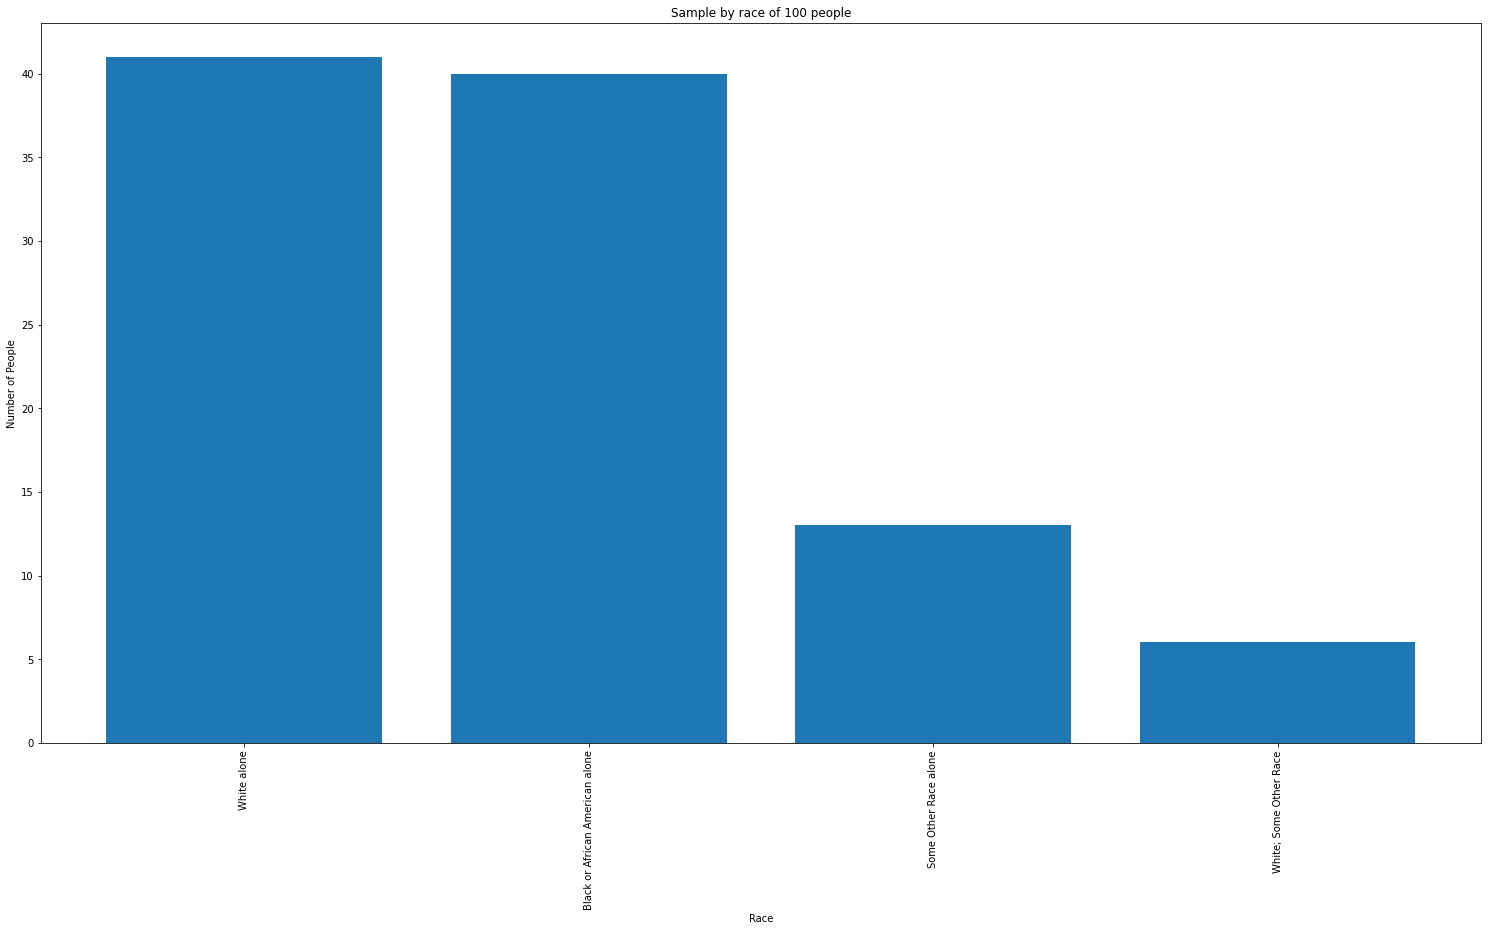

In [ ]:
sample = newBlock.getSample(100)
plotSample(sample)

### Tract

In [ ]:
import matplotlib.pyplot as plt
class TractByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("Tract")
      if (len(FIPS) != 11):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear, for_unit="tract")
        return self._decennial_data



In [ ]:
newTract = TractByFIPS("17031837100")
newTract

<Unit administrative_unit:Tract, 
    FIPS:17031837100, 
    decennial_data: 
 GEO_ID                         1400000US17031837100
NAME       Census Tract 8371, Cook County, Illinois
P1_001N                                        1652
P1_002N                                        1536
P1_003N                                         240
                             ...                   
P1_070N                                           0
P1_071N                                           0
state                                            17
county                                          031
tract                                        837100
Length: 76, dtype: object>

['White alone', 'Black or African American alone', 'Asian alone', 'Native Hawaiian and Other Pacific Islander alone', 'Some Other Race alone', 'White; Black or African American', 'White; American Indian and Alaska Native', 'White; Asian', 'White; Some Other Race', 'Black or African American; American Indian and Alaska Native', 'Black or African American; Some Other Race', 'American Indian and Alaska Native; Some Other Race', 'White; Black or African American; Asian', 'White; Black or African American; Some Other Race', 'White; American Indian and Alaska Native; Some Other Race']
[158, 696, 11, 1, 73, 22, 2, 5, 15, 2, 1, 5, 1, 6, 2]


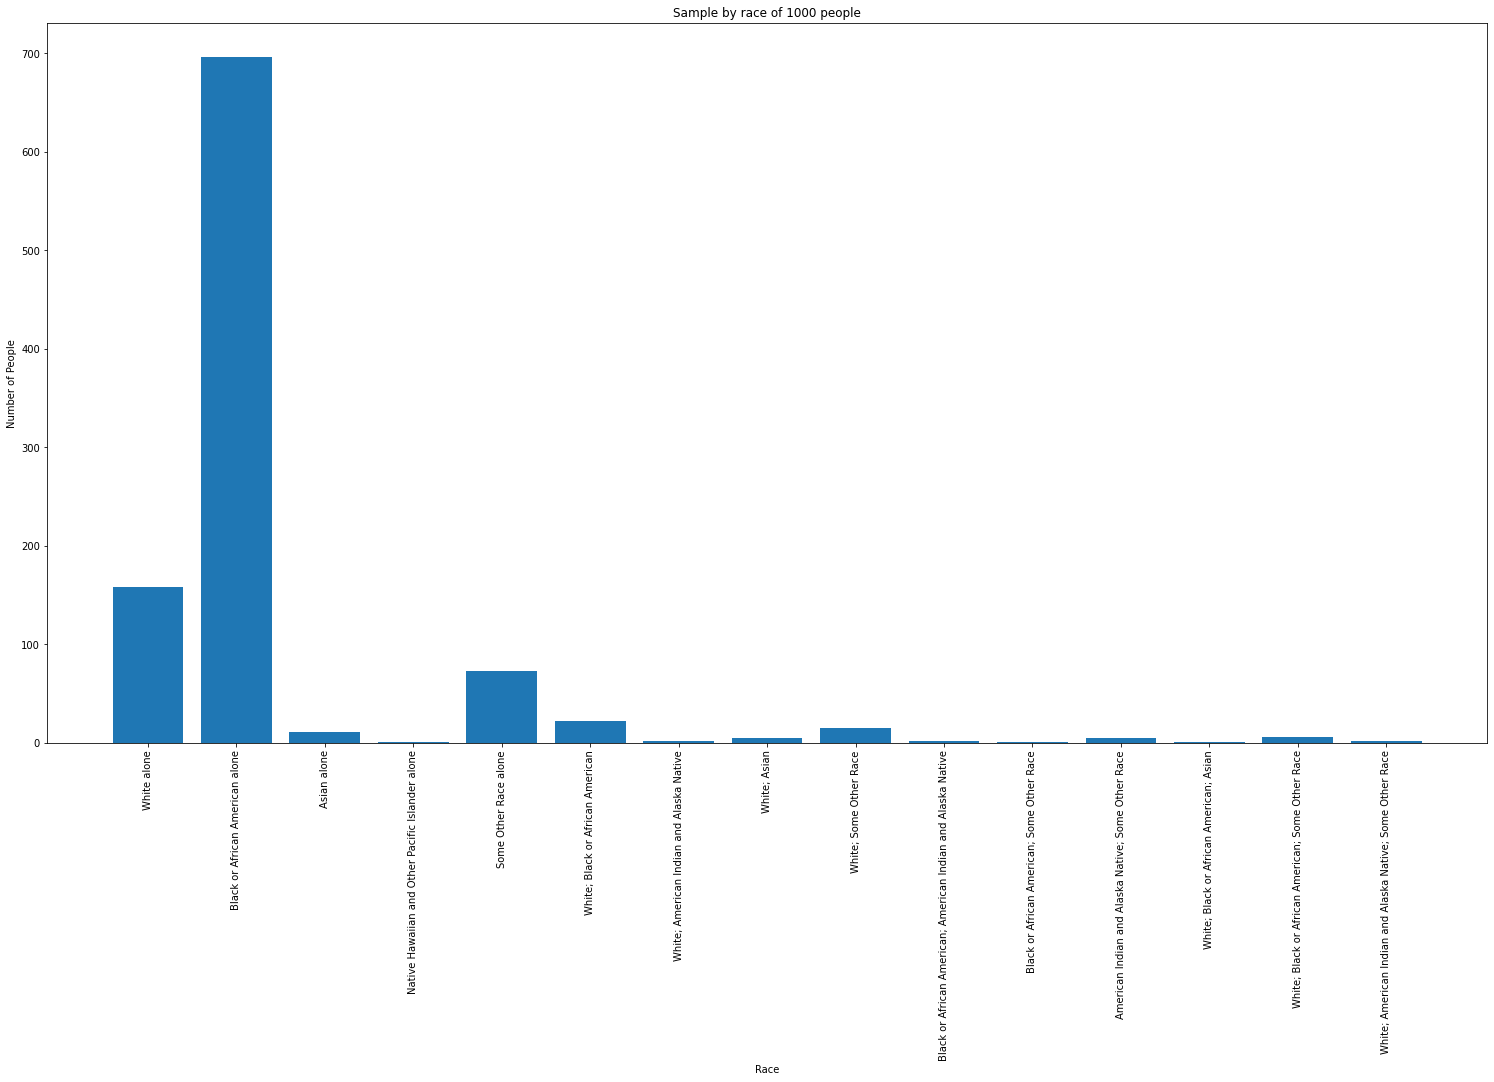

In [ ]:
sample = newTract.getSample(1000)
plotSample(sample)

### County

In [ ]:
import matplotlib.pyplot as plt
class CountyByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("County")
      if (len(FIPS) != 5):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear, for_unit="county")
        return self._decennial_data



In [ ]:
newCounty = CountyByFIPS("17031")
newCounty

<Unit administrative_unit:County, 
    FIPS:17031, 
    decennial_data: 
 GEO_ID            0500000US17031
NAME       Cook County, Illinois
P1_001N                  5275541
P1_002N                  4728989
P1_003N                  2345983
                   ...          
P1_069N                        1
P1_070N                       36
P1_071N                       36
state                         17
county                       031
Length: 75, dtype: object>

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



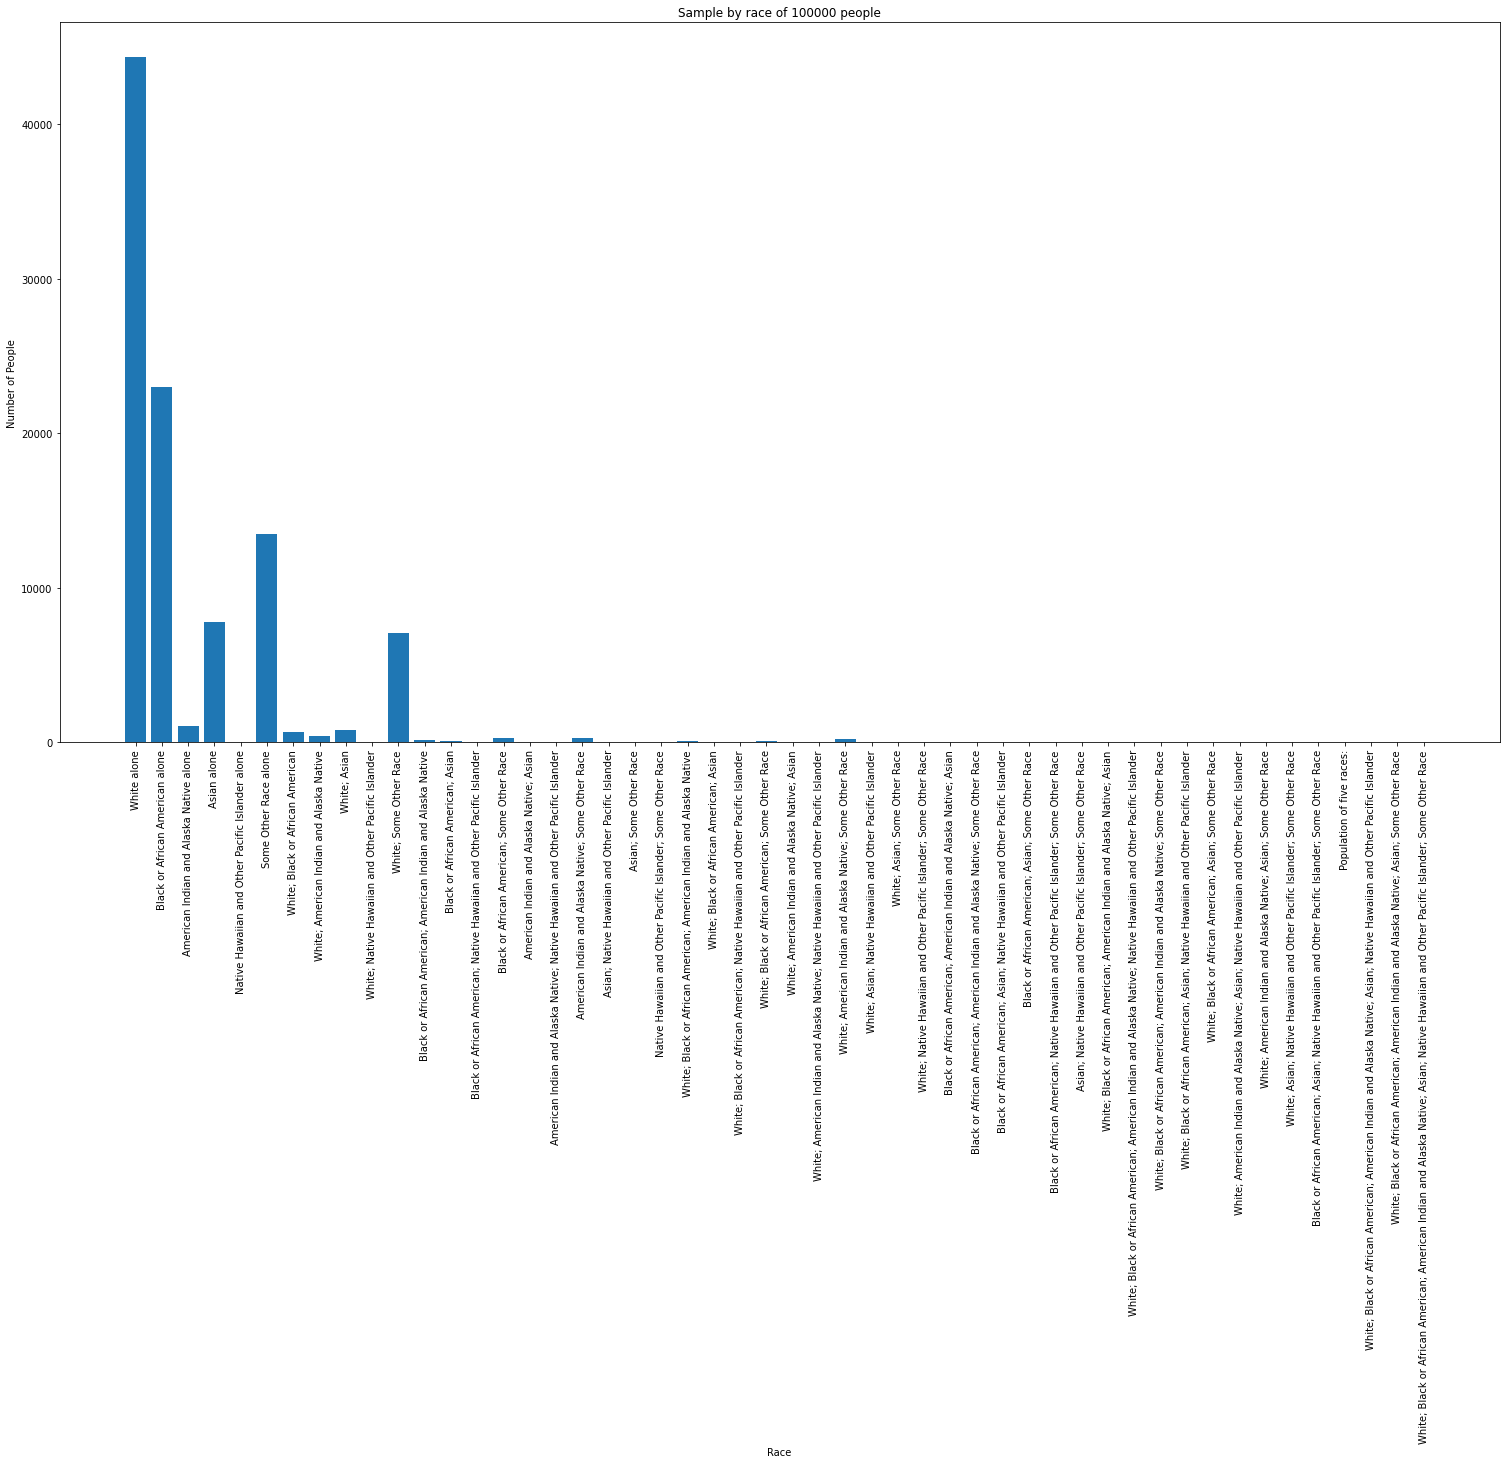

In [ ]:
sample = newCounty.getSample(100000)
print(sample)
plotSample(sample)

In [ ]:
getFIPS(41.886269657542044, -87.70033108160133, year = "2020")

{"Block":{"FIPS":"170318371002011","bbox":[-87.701359,41.885909,-87.69888,41.886508]},"County":{"FIPS":"17031","name":"Cook County"},"State":{"FIPS":"17","code":"IL","name":"Illinois"},"status":"OK","executionTime":"0"}


'170318371002011'

### State

In [ ]:
import matplotlib.pyplot as plt
class StateByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("State")
      if (len(FIPS) != 2):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear, for_unit="state")
        return self._decennial_data



In [ ]:
newState = StateByFIPS("17")
newState

<Unit administrative_unit:State, 
    FIPS:17, 
    decennial_data: 
 GEO_ID     0400000US17
NAME          Illinois
P1_001N       12812508
P1_002N       11667524
P1_003N        7868227
              ...     
P1_068N              4
P1_069N             15
P1_070N             84
P1_071N             84
state               17
Length: 74, dtype: object>

['White alone', 'Black or African American alone', 'American Indian and Alaska Native alone', 'Asian alone', 'Native Hawaiian and Other Pacific Islander alone', 'Some Other Race alone', 'White; Black or African American', 'White; American Indian and Alaska Native', 'White; Asian', 'White; Native Hawaiian and Other Pacific Islander', 'White; Some Other Race', 'Black or African American; American Indian and Alaska Native', 'Black or African American; Asian', 'Black or African American; Native Hawaiian and Other Pacific Islander', 'Black or African American; Some Other Race', 'American Indian and Alaska Native; Asian', 'American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander', 'American Indian and Alaska Native; Some Other Race', 'Asian; Native Hawaiian and Other Pacific Islander', 'Asian; Some Other Race', 'Native Hawaiian and Other Pacific Islander; Some Other Race', 'White; Black or African American; American Indian and Alaska Native', 'White; Black or African Ame

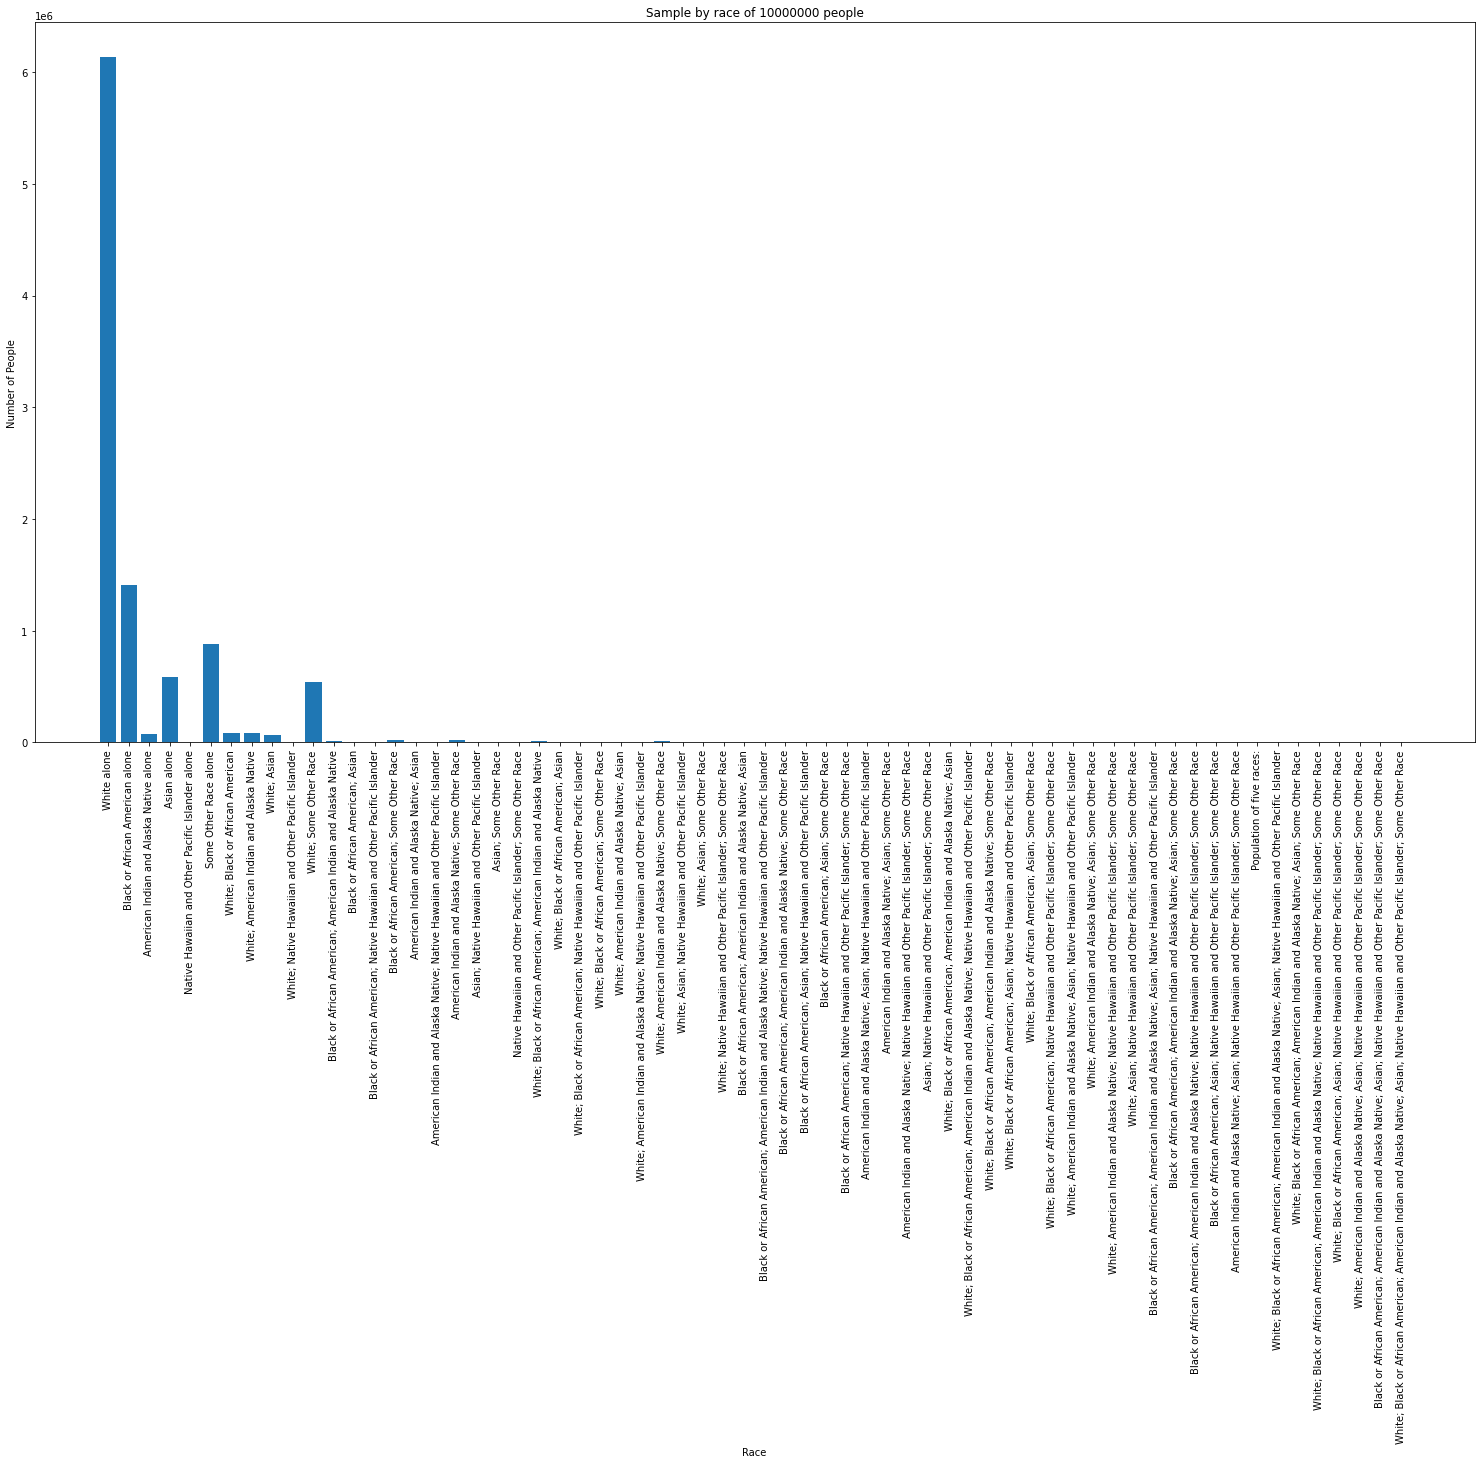

In [ ]:
sample = newState.getSample(10000000)
plotSample(sample)

## Geolocation inputs
Working with input from latitude and longitude, we can convert it into FIPS using the API from Federal Communication Commission using the `getFIPS()` function. 

In [ ]:
class BlockByLoc(BlockByFIPS):
    def __init__(self, lat, lon, censusYear = "2020"):  
        FIPS = getFIPS(lat, lon, year = censusYear)
        super().__init__(FIPS, censusYear)

class CountyByLoc(CountyByFIPS):
    def __init__(self, lat, lon, censusYear = "2020"):  
        FIPS = getFIPS(lat, lon, year = censusYear, division="County")
        super().__init__(FIPS, censusYear)

class StateByLoc(StateByFIPS):
    def __init__(self, lat, lon, censusYear = "2020"):  
        FIPS = getFIPS(lat, lon, year = censusYear, division="State")
        super().__init__(FIPS, censusYear)


For instance, we get the County data based on `lat=41.871939, lon=-87.649470`:

In [ ]:
newCounty = CountyByLoc(lat=41.871939, lon=-87.649470)
newCounty

{"Block":{"FIPS":"170318419001043","bbox":[-87.651808,41.869508,-87.647064,41.874375]},"County":{"FIPS":"17031","name":"Cook County"},"State":{"FIPS":"17","code":"IL","name":"Illinois"},"status":"OK","executionTime":"0"}


<Unit administrative_unit:County, 
    FIPS:17031, 
    decennial_data: 
 GEO_ID            0500000US17031
NAME       Cook County, Illinois
P1_001N                  5275541
P1_002N                  4728989
P1_003N                  2345983
                   ...          
P1_069N                        1
P1_070N                       36
P1_071N                       36
state                         17
county                       031
Length: 75, dtype: object>

# Group
Assume you want to gather information and analyze of a list of `Block` that have the same `State` FIPS, we would use this class.

### Unit By Decennial Data

For each retrieval of `Group` data, we would obtain a large table of `Unit` data. Therefore, a new class of `Unit` is required that can accept input from a sequence of `DecennialData`.

In [ ]:
class UnitByDecennialData(Unit):
    def __init__(self, decennialData, cummulativeDecennialData = None):
        if not isinstance(decennialData, pd.Series):
            raise("The DecennialData must be a panda Series")
        if ('state' in decennialData.index):
            state = str(decennialData['state'])
            self._administrative_unit = 'State'
        else:
            state = ""
        
        if ('county' in decennialData.index):
            county = str(decennialData['county'])
            self._administrative_unit = 'County'
        else:
            county = ""

        if ('tract' in decennialData.index):
            tract = str(decennialData['tract'])
            self._administrative_unit = 'Tract'
        else:
            tract = ""

        if ('block' in decennialData.index):
            block = str(decennialData['block'])
            self._administrative_unit = 'Block'
        else:
            block = ""
        
        self._FIPS = state + county + tract + block
        self._censusYear = None
        self._group = None
        self._decennial_data = decennialData
        self._decennial_data_cumulative = cummulativeDecennialData

In [ ]:
newTract = UnitByDecennialData(getDecennialData("17031841900", for_unit='tract'))
print(newTract)

<Unit administrative_unit:Tract, 
    FIPS:17031841900, 
    decennial_data: 
 GEO_ID                         1400000US17031841900
NAME       Census Tract 8419, Cook County, Illinois
P1_001N                                        6500
P1_002N                                        6152
P1_003N                                        2542
                             ...                   
P1_070N                                           0
P1_071N                                           0
state                                            17
county                                          031
tract                                        841900
Length: 76, dtype: object>


In [ ]:
len(newTract.group)

64

## Group class

In [ ]:
class Group(UnitInterface):
    def __init__(self, FIPS, group_level, unit_level, census_year = "2020"):
        self._administrative_unit = group_level
        self._FIPS = FIPS
        self._unit_level = unit_level
        self._censusYear = census_year
        self._decennial_data = None
        self._decennial_data_cumulative = None
        self._group = None

    @property
    def administrativeUnit(self):
        return self._administrative_unit

    @property
    def FIPS(self):
        return self._FIPS

    @FIPS.setter
    def FIPS(self, fips):
      self._FIPS = fips
    
    @property
    def censusYear(self):
        return self._censusYear

    @censusYear.setter
    def censusYear(self, censusYear):
      self._censusYear = censusYear
    
    @property
    def decennialData(self):
        return self._decennial_data

    @decennialData.setter
    def decennialData(self, decennial_data):
        self._decennial_data = decennial_data

    @property
    def group(self):
      if (self._group is None):
          self._group = [ 'P1_003N', 'P1_004N', 'P1_005N',
                          'P1_006N', 'P1_007N', 'P1_008N', 'P1_011N',
                          'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
                          'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
                          'P1_024N', 'P1_025N', 'P1_027N', 'P1_028N', 'P1_029N',
                          'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
                          'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
                          'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 
                          'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
                          'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
                          'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N', 'P1_064N', 'P1_065N',
                          'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N', 'P1_071N']
      return self._group

    @group.setter
    def group(self, group):
        self._group = group
        self._decennial_data_cumulative = None

    def setGroup(self, group):
        self._group = group
        self._decennial_data_cumulative = None
        return self

    @property
    def Units(self):
        return self._units

    @property
    def decennialDataCumulative(self):
        if (self._decennial_data_cumulative is None):
            decennial_data_processed = self.decennialData[self.group] 
            decennial_data_processed = decennial_data_processed.apply(pd.to_numeric, errors='ignore')

            print(decennial_data_processed)
            decennial_data_processed = decennial_data_processed.sum(axis = 1)
            decennial_data_processed.index = map(str, decennial_data_processed.index)
            decennial_data_processed = decennial_data_processed[decennial_data_processed > 0]
            print(decennial_data_processed)
            if (decennial_data_processed.size == 0):
                print('No Population')
            self._decennial_data_cumulative = decennial_data_processed.cumsum()
            self._decennial_data_cumulative = self._decennial_data_cumulative * 1.0 / self._decennial_data_cumulative.max()
        return self._decennial_data_cumulative

    @decennialDataCumulative.setter
    def decennialDataCumulative(self, decennial_data_cumulative):
        self._decennial_data_cumulative = decennial_data_cumulative

    def __repr__(self):
        return f"<Group administrative_unit:{self._administrative_unit}, \n element_unit:{self._unit_level}, \n     FIPS:{self._FIPS}, \n    decennial_data: \n {self.decennialData}>"

    def getSample(self, n = 1, group = None):
        randomFloat = np.random.random_sample(size = n)
        indexNum = self.decennialDataCumulative.searchsorted(randomFloat, side="right")
        indexes, num_people = np.unique(indexNum, return_counts=True)
        decennial_data_indexes = list(map(lambda x: self.decennialDataCumulative.index[x], indexes))
        sample = []
        for i in range(len(decennial_data_indexes)):
            sample.extend(UnitByDecennialData(self.decennialData.iloc[int(decennial_data_indexes[i])]).setGroup(self.group).getSample(num_people[i]))
        return sample

    def graphDecennialData(self):
        self.getProcessedDecennialData()
        self._decennial_data.plot( kind = 'bar')
        plt.show()

In [ ]:
class StateByBlockGroup(Group):
    def __init__(self, FIPS, census_year = "2020"):
        if (len(FIPS) != 2):
            raise Exception("fips length is invalid")
        super().__init__(FIPS, group_level = "State", unit_level = "Block", census_year = census_year)

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS,  for_unit = 'block', year = self._censusYear)
        return self._decennial_data
        
class TractByBlockGroup(Group):
    def __init__(self, FIPS, census_year = "2020"):
        if (len(FIPS) != 11):
            raise Exception("fips length is invalid")
        super().__init__(FIPS, group_level = "Tract", unit_level = "Block", census_year = census_year)

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS,  for_unit = 'block', year = self._censusYear, )
        return self._decennial_data

In [ ]:
newTract = TractByBlockGroup("17031837100")

In [ ]:
newTract.decennialData

,GEO_ID,NAME,P1_001N,P1_001NA,P1_002N,P1_002NA,P1_003N,P1_003NA,P1_004N,P1_004NA,...,P1_069N,P1_069NA,P1_070N,P1_070NA,P1_071N,P1_071NA,state,county,tract,block
0,1000000US170318371001000,"Block 1000, Block Group 1, Census Tract 8371, ...",13,None,11,None,7,None,2,None,...,0,None,0,None,0,None,17,031,837100,1000
1,1000000US170318371001001,"Block 1001, Block Group 1, Census Tract 8371, ...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,031,837100,1001
2,1000000US170318371001002,"Block 1002, Block Group 1, Census Tract 8371, ...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,031,837100,1002
3,1000000US170318371001003,"Block 1003, Block Group 1, Census Tract 8371, ...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,031,837100,1003
4,1000000US170318371001004,"Block 1004, Block Group 1, Census Tract 8371, ...",24,None,23,None,9,None,14,None,...,0,None,0,None,0,None,17,031,837100,1004
5,1000000US170318371001005,"Block 1005, Block Group 1, Census Tract 8371, ...",10,None,7,None,0,None,6,None,...,0,None,0,None,0,None,17,031,837100,1005
6,1000000US170318371001006,"Block 1006, Block Group 1, Census Tract 8371, ...",65,None,60,None,5,None,52,None,...,0,None,0,None,0,None,17,031,837100,1006
7,1000000US170318371001007,"Block 1007, Block Group 1, Census Tract 8371, ...",45,None,44,None,11,None,23,None,...,0,None,0,None,0,None,17,031,837100,1007
8,1000000US170318371001008,"Block 1008, Block Group 1, Census Tract 8371, ...",235,None,225,None,15,None,202,None,...,0,None,0,None,0,None,17,031,837100,1008
9,1000000US170318371001009,"Block 1009, Block Group 1, Census Tract 8371, ...",48,None,44,None,15,None,29,None,...,0,None,0,None,0,None,17,031,837100,1009


In [ ]:
newTract.decennialDataCumulative

    P1_003N  P1_004N  P1_005N  P1_006N  P1_007N  P1_008N  P1_011N  P1_012N  \
0         7        2        0        2        0        0        2        0   
1         0        0        0        0        0        0        0        0   
2         0        0        0        0        0        0        0        0   
3         0        0        0        0        0        0        0        0   
4         9       14        0        0        0        0        0        0   
5         0        6        0        0        0        1        0        0   
6         5       52        0        0        0        3        4        0   
7        11       23        0        0        0       10        0        0   
8        15      202        0        0        0        8       10        0   
9        15       29        0        0        0        0        0        0   
10        3        8        0        0        0        4        0        0   
11       25       77        0        0        2        6        

0     0.007869
4     0.022397
5     0.028450
6     0.067797
7     0.095036
8     0.237288
9     0.266344
10    0.277240
11    0.348668
12    0.356538
15    0.377119
17    0.388620
18    0.440073
19    0.447942
22    0.449758
23    0.458232
25    0.491525
26    0.496368
27    0.507869
28    0.565981
29    0.601695
30    0.613801
31    0.640436
32    0.651937
34    0.656780
35    0.700969
36    0.737893
37    0.762107
39    0.783293
40    0.797215
41    0.811138
42    0.842010
43    0.851695
44    0.869855
45    0.921308
46    0.984867
47    1.000000
dtype: float64

In [ ]:
sample = newTract.getSample(500)
sample

[<Person block_FIPS:170318371001000, race:P1_003N>,
 <Person block_FIPS:170318371001000, race:P1_004N>,
 <Person block_FIPS:170318371001000, race:P1_003N>,
 <Person block_FIPS:170318371001000, race:P1_003N>,
 <Person block_FIPS:170318371001004, race:P1_003N>,
 <Person block_FIPS:170318371001004, race:P1_003N>,
 <Person block_FIPS:170318371001004, race:P1_003N>,
 <Person block_FIPS:170318371001004, race:P1_004N>,
 <Person block_FIPS:170318371001004, race:P1_003N>,
 <Person block_FIPS:170318371001005, race:P1_004N>,
 <Person block_FIPS:170318371001005, race:P1_013N>,
 <Person block_FIPS:170318371001005, race:P1_004N>,
 <Person block_FIPS:170318371001006, race:P1_004N>,
 <Person block_FIPS:170318371001006, race:P1_015N>,
 <Person block_FIPS:170318371001006, race:P1_004N>,
 <Person block_FIPS:170318371001006, race:P1_004N>,
 <Person block_FIPS:170318371001006, race:P1_004N>,
 <Person block_FIPS:170318371001006, race:P1_004N>,
 <Person block_FIPS:170318371001006, race:P1_004N>,
 <Person blo

['White alone', 'Black or African American alone', 'American Indian and Alaska Native alone', 'Asian alone', 'Some Other Race alone', 'White; Black or African American', 'White; American Indian and Alaska Native', 'White; Asian', 'White; Some Other Race', 'Black or African American; Some Other Race', 'American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander', 'American Indian and Alaska Native; Some Other Race', 'White; Black or African American; Some Other Race']
[83, 344, 1, 11, 24, 10, 4, 1, 15, 2, 1, 1, 3]


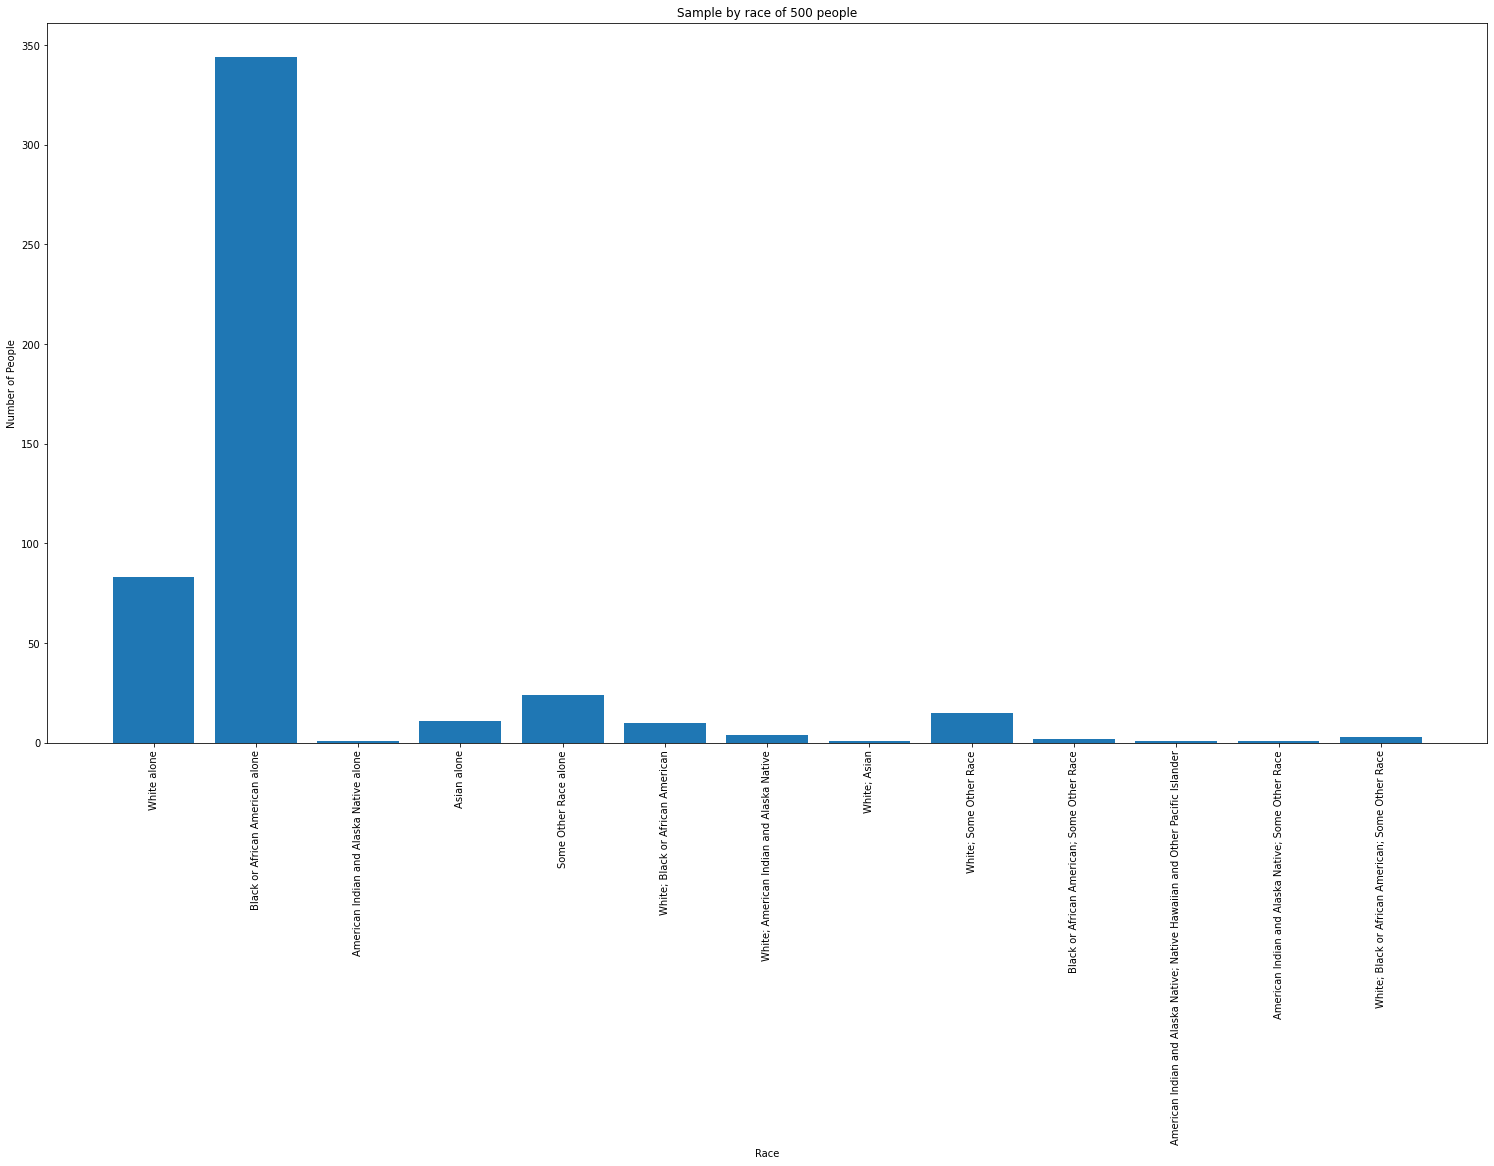

In [ ]:
plotSample(sample)

+ Add information about the code : "17", the groups

In [ ]:
newState = StateByBlockGroup("17").setGroup(["P1_003N","P1_004N"])

In [ ]:
newState.decennialData

,GEO_ID,NAME,P1_001N,P1_001NA,P1_002N,P1_002NA,P1_003N,P1_003NA,P1_004N,P1_004NA,...,P1_069N,P1_069NA,P1_070N,P1_070NA,P1_071N,P1_071NA,state,county,tract,block
0,1000000US170010001001000,"Block 1000, Block Group 1, Census Tract 1, Ada...",17,None,17,None,16,None,1,None,...,0,None,0,None,0,None,17,001,000100,1000
1,1000000US170010001001001,"Block 1001, Block Group 1, Census Tract 1, Ada...",2,None,2,None,1,None,0,None,...,0,None,0,None,0,None,17,001,000100,1001
2,1000000US170010001001002,"Block 1002, Block Group 1, Census Tract 1, Ada...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,001,000100,1002
3,1000000US170010001001003,"Block 1003, Block Group 1, Census Tract 1, Ada...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,001,000100,1003
4,1000000US170010001001004,"Block 1004, Block Group 1, Census Tract 1, Ada...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,001,000100,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369973,1000000US172030307003228,"Block 3228, Block Group 3, Census Tract 307, W...",11,None,11,None,11,None,0,None,...,0,None,0,None,0,None,17,203,030700,3228
369974,1000000US172030307003229,"Block 3229, Block Group 3, Census Tract 307, W...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,203,030700,3229
369975,1000000US172030307003230,"Block 3230, Block Group 3, Census Tract 307, W...",0,None,0,None,0,None,0,None,...,0,None,0,None,0,None,17,203,030700,3230
369976,1000000US172030307003231,"Block 3231, Block Group 3, Census Tract 307, W...",7,None,6,None,6,None,0,None,...,0,None,0,None,0,None,17,203,030700,3231


In [ ]:
newState
sample = newState.getSample(10000)
sample

        P1_003N  P1_004N
0            16        1
1             1        0
2             0        0
3             0        0
4             0        0
...         ...      ...
369973       11        0
369974        0        0
369975        0        0
369976        6        0
369977        0        0

[369978 rows x 2 columns]
0          17
1           1
7          41
8         198
9          19
         ... 
369962      8
369968      4
369971      5
369973     11
369976      6
Length: 274050, dtype: int64


[<Person block_FIPS:170010001001008, race:P1_003N>,
 <Person block_FIPS:170010001001011, race:P1_003N>,
 <Person block_FIPS:170010001001037, race:P1_003N>,
 <Person block_FIPS:170010001003004, race:P1_003N>,
 <Person block_FIPS:170010001003020, race:P1_003N>,
 <Person block_FIPS:170010001005005, race:P1_003N>,
 <Person block_FIPS:170010002012013, race:P1_003N>,
 <Person block_FIPS:170010002021002, race:P1_004N>,
 <Person block_FIPS:170010002022018, race:P1_003N>,
 <Person block_FIPS:170010002022025, race:P1_003N>,
 <Person block_FIPS:170010004001004, race:P1_003N>,
 <Person block_FIPS:170010004002012, race:P1_003N>,
 <Person block_FIPS:170010004003016, race:P1_003N>,
 <Person block_FIPS:170010004004000, race:P1_003N>,
 <Person block_FIPS:170010005001018, race:P1_003N>,
 <Person block_FIPS:170010005002002, race:P1_003N>,
 <Person block_FIPS:170010005002007, race:P1_004N>,
 <Person block_FIPS:170010006002000, race:P1_003N>,
 <Person block_FIPS:170010007002002, race:P1_003N>,
 <Person blo

['White alone', 'Black or African American alone']
[8131, 1869]


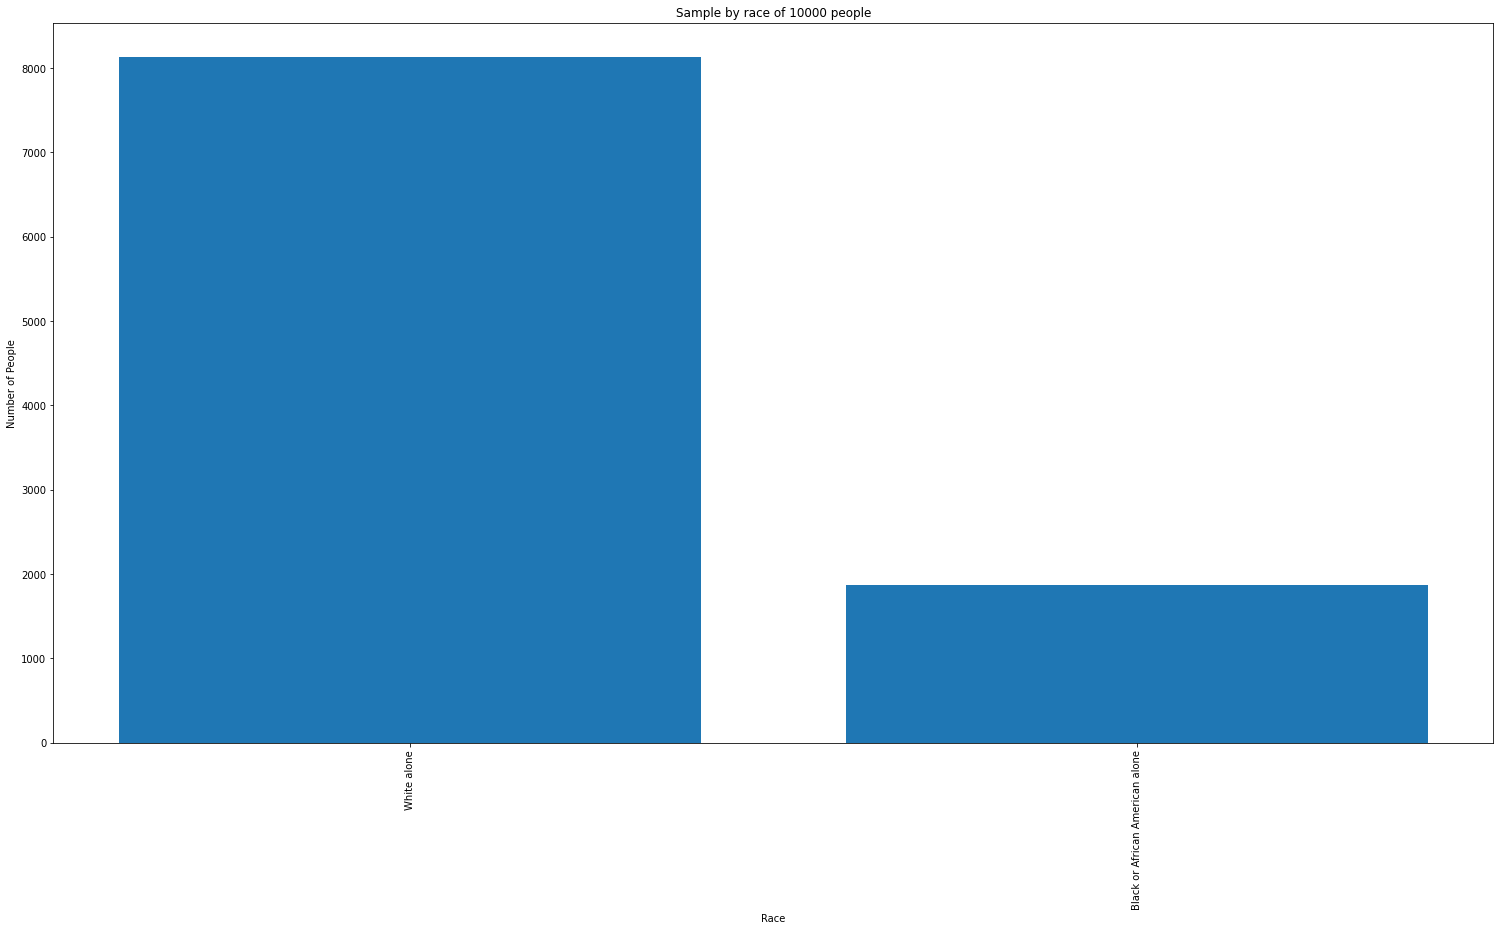

In [ ]:
plotSample(sample)

In [ ]:
newState.setGroup(["P1_003N"])
sample = newState.getSample(10000)
sample

        P1_003N
0            16
1             1
2             0
3             0
4             0
...         ...
369973       11
369974        0
369975        0
369976        6
369977        0

[369978 rows x 1 columns]
0          16
1           1
7          39
8         198
9          18
         ... 
369962      7
369968      4
369971      5
369973     11
369976      6
Length: 261458, dtype: int64


[<Person block_FIPS:170010001001048, race:P1_003N>,
 <Person block_FIPS:170010001002004, race:P1_003N>,
 <Person block_FIPS:170010001003016, race:P1_003N>,
 <Person block_FIPS:170010001004000, race:P1_003N>,
 <Person block_FIPS:170010001004014, race:P1_003N>,
 <Person block_FIPS:170010001005006, race:P1_003N>,
 <Person block_FIPS:170010002021001, race:P1_003N>,
 <Person block_FIPS:170010002021008, race:P1_003N>,
 <Person block_FIPS:170010002021008, race:P1_003N>,
 <Person block_FIPS:170010002022020, race:P1_003N>,
 <Person block_FIPS:170010002022023, race:P1_003N>,
 <Person block_FIPS:170010002022025, race:P1_003N>,
 <Person block_FIPS:170010004001008, race:P1_003N>,
 <Person block_FIPS:170010004001013, race:P1_003N>,
 <Person block_FIPS:170010004002025, race:P1_003N>,
 <Person block_FIPS:170010004002026, race:P1_003N>,
 <Person block_FIPS:170010004003035, race:P1_003N>,
 <Person block_FIPS:170010005001004, race:P1_003N>,
 <Person block_FIPS:170010005002011, race:P1_003N>,
 <Person blo

['White alone']
[10000]


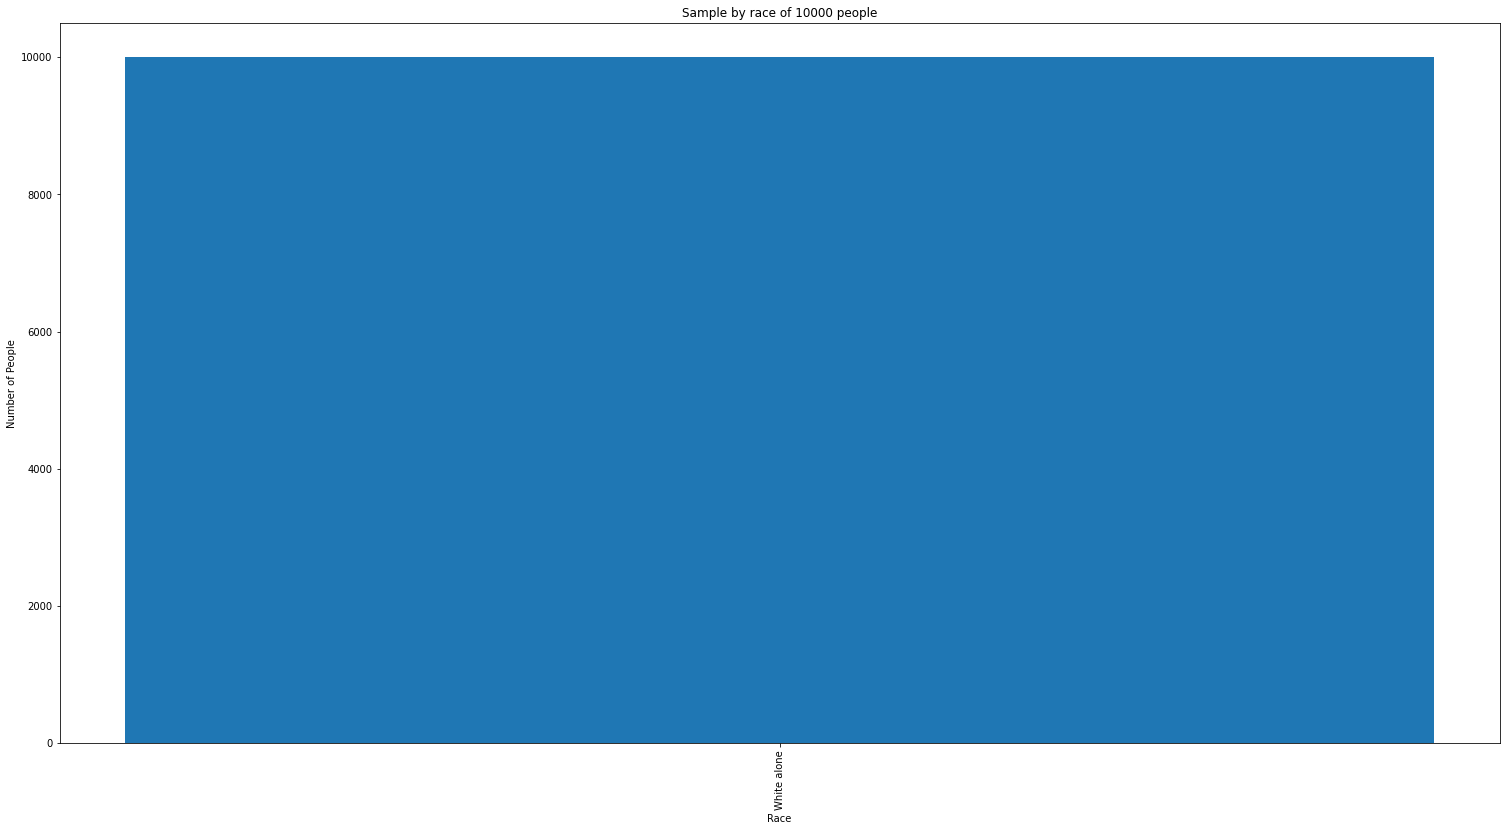

In [ ]:
plotSample(sample)

# Sample Geographical Plotting


## Needed library

In [ ]:
! pip install pyshp geopandas mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 803 kB/s 
     |████████████████████████████████| 1.0 MB 29.2 MB/s 
     |████████████████████████████████| 6.3 MB 43.9 MB/s 
     |████████████████████████████████| 16.7 MB 63.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

## Get Geographical DataFile

In [ ]:
def downloadShapeFile(FIPS, unit_level = 'block'):
    try:
        if (unit_level == 'state'):
            url = "https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip"
        elif (unit_level == 'county'):
            url = "https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip"
        elif (unit_level == 'tract'):
            url = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_"+str(FIPS[0:2])+"_tract.zip"
        elif (unit_level == 'block'):
            url = "https://www2.census.gov/geo/tiger/TIGER2021/TABBLOCK20/tl_2021_"+str(FIPS[0:2])+"_tabblock20.zip"
        response = requests.get(url)
        filename = url.split('/')[-1]
        with open(filename,'wb') as output_file:
            output_file.write(response.content)
        print('Downloading Completed')
        response.close()
        return filename

    except requests.ConnectionError as error:
        print("Cannot download ShapeFile")
        print(error)

## Loading FileShape

In [ ]:
import os;
import geopandas as gpd;
def loadShapeFile(FIPS, unit_level = 'block'):
        if (unit_level == 'state'):
            filename = "tl_2021_us_state.zip"
        elif (unit_level == 'county'):
            filename = "tl_2021_us_county.zip"
        elif (unit_level == 'tract'):
            filename = "tl_2021_"+str(FIPS[0:2])+"_tract.zip"
        elif (unit_level == 'block'):
            filename = "tl_2021_"+str(FIPS[0:2])+"_tabblock20.zip"
        else:
            raise Exception("Unknown unit level")

        if(not os.path.exists(filename)):
            filename = downloadShapeFile(FIPS, unit_level)

        sf = gpd.read_file(os.path.join(os.getcwd(),filename))
        return sf


In [ ]:
sf = loadShapeFile("17")

In [ ]:
sf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,17,169,970100,2104,171699701002104,Block 2104,G5040,R,None,None,S,3669538,0,+40.1309011,-090.6038663,"POLYGON ((-90.62795 40.12222, -90.62693 40.123..."
1,17,169,970100,2124,171699701002124,Block 2124,G5040,R,None,None,S,758164,0,+40.1232038,-090.5980559,"POLYGON ((-90.61291 40.12184, -90.61254 40.121..."
2,17,169,970200,2030,171699702002030,Block 2030,G5040,R,None,None,S,9692,0,+40.1234691,-090.5697596,"POLYGON ((-90.57035 40.12321, -90.57035 40.123..."
3,17,169,970100,1098,171699701001098,Block 1098,G5040,R,None,None,S,4297,0,+40.1790079,-090.8060421,"POLYGON ((-90.80675 40.17929, -90.80661 40.179..."
4,17,169,970100,2199,171699701002199,Block 2199,G5040,R,None,None,S,1923285,0,+40.2384717,-090.6642980,"POLYGON ((-90.67845 40.23654, -90.67844 40.238..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369973,17,057,953900,3073,170579539003073,Block 3073,G5040,R,None,None,S,11060,0,+40.2274219,-090.3603868,"POLYGON ((-90.36100 40.22723, -90.36101 40.227..."
369974,17,057,953900,3074,170579539003074,Block 3074,G5040,R,None,None,S,11108,0,+40.2274160,-090.3591586,"POLYGON ((-90.35977 40.22782, -90.35977 40.227..."
369975,17,057,953900,1052,170579539001052,Block 1052,G5040,R,None,None,S,21901,0,+40.2273887,-090.3561496,"POLYGON ((-90.35735 40.22766, -90.35734 40.227..."
369976,17,057,953900,1046,170579539001046,Block 1046,G5040,R,None,None,S,10227,0,+40.2282870,-090.3532300,"POLYGON ((-90.35380 40.22869, -90.35379 40.228..."


## Get ShapeFile DataFrame based on FIPS

In [ ]:
def getSFDF(FIPS, for_unit='block'):
    df = loadShapeFile(FIPS, for_unit)
    columns = df.columns.values.tolist()
    new_columns = list(map((lambda x: x[:-2] if ("20" in x) else x), columns))
    df = df.rename(columns=dict(zip(columns, new_columns))) 
    if (len(FIPS) >= 2):
      df = df[df.STATEFP == FIPS[0:2]]
    if (len(FIPS) >= 5):
      df = df[df.COUNTYFP == FIPS[2:5]]
    if (len(FIPS) >= 11):
      df = df[df.TRACTCE == FIPS[5:11]]
    if (len(FIPS) == 15):
      df = df[df.BLOCKCE == FIPS[11:15]]
    return df

In [ ]:
df = getSFDF("17031837100")
df

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,GEOID,NAME,MTFCC,UR,UACE,UATYPE,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
91168,17,031,837100,1009,170318371001009,Block 1009,G5040,R,None,None,S,11155,0,+41.8856582,-087.7050259,"POLYGON ((-87.70627 41.88589, -87.70457 41.885..."
101214,17,031,837100,1010,170318371001010,Block 1010,G5040,R,None,None,S,25713,0,+41.8848456,-087.7049705,"POLYGON ((-87.70625 41.88540, -87.70576 41.885..."
112128,17,031,837100,2011,170318371002011,Block 2011,G5040,R,None,None,S,12925,0,+41.8862076,-087.7001213,"POLYGON ((-87.70136 41.88648, -87.70087 41.886..."
119925,17,031,837100,1008,170318371001008,Block 1008,G5040,R,None,None,S,23269,0,+41.8859531,-087.7025724,"POLYGON ((-87.70382 41.88645, -87.70361 41.886..."
119926,17,031,837100,2010,170318371002010,Block 2010,G5040,R,None,None,S,13078,0,+41.8867802,-087.7001331,"POLYGON ((-87.70138 41.88705, -87.69891 41.887..."
119927,17,031,837100,2009,170318371002009,Block 2009,G5040,R,None,None,S,6842,0,+41.8867770,-087.6981922,"POLYGON ((-87.69891 41.88703, -87.69751 41.887..."
127200,17,031,837100,1011,170318371001011,Block 1011,G5040,R,None,None,S,11901,0,+41.8851772,-087.7025518,"POLYGON ((-87.70379 41.88543, -87.70330 41.885..."
129765,17,031,837100,2015,170318371002015,Block 2015,G5040,R,None,None,S,21149,0,+41.8852027,-087.6957854,"POLYGON ((-87.69642 41.88612, -87.69519 41.886..."
130140,17,031,837100,1012,170318371001012,Block 1012,G5040,R,None,None,S,17574,0,+41.8845261,-087.7024892,"POLYGON ((-87.70377 41.88490, -87.70140 41.884..."
131138,17,031,837100,1002,170318371001002,Block 1002,G5040,R,None,None,S,5116,0,+41.8872932,-087.7033180,"POLYGON ((-87.70386 41.88755, -87.70364 41.887..."


In [ ]:
df2 = getSFDF("17031")
df2

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,GEOID,NAME,MTFCC,UR,UACE,UATYPE,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
43895,17,031,803604,1004,170318036041004,Block 1004,G5040,R,None,None,S,10765,0,+42.1253541,-088.0432581,"POLYGON ((-88.04378 42.12625, -88.04364 42.126..."
43896,17,031,803604,1000,170318036041000,Block 1000,G5040,R,None,None,S,6240,0,+42.1249884,-088.0400862,"POLYGON ((-88.04107 42.12482, -88.04087 42.124..."
43897,17,031,803605,4007,170318036054007,Block 4007,G5040,R,None,None,S,13289,0,+42.1283062,-088.0219304,"POLYGON ((-88.02408 42.12831, -88.02408 42.128..."
43898,17,031,803605,1006,170318036051006,Block 1006,G5040,R,None,None,S,43305,0,+42.1346401,-088.0252379,"POLYGON ((-88.02646 42.13379, -88.02645 42.133..."
43899,17,031,808301,1009,170318083011009,Block 1009,G5040,R,None,None,S,311638,0,+42.0299568,-087.7927043,"POLYGON ((-87.79451 42.03325, -87.79448 42.033..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362627,17,031,813802,1008,170318138021008,Block 1008,G5040,R,None,None,S,10349,0,+41.8472774,-087.7527337,"POLYGON ((-87.75398 41.84749, -87.75348 41.847..."
362628,17,031,813801,1007,170318138011007,Block 1007,G5040,R,None,None,S,7510,0,+41.8473512,-087.7474863,"POLYGON ((-87.74839 41.84757, -87.74750 41.847..."
362629,17,031,813801,1010,170318138011010,Block 1010,G5040,R,None,None,S,7560,0,+41.8464390,-087.7474528,"POLYGON ((-87.74836 41.84665, -87.74746 41.846..."
362630,17,031,813801,1013,170318138011013,Block 1013,G5040,R,None,None,S,7537,0,+41.8459829,-087.7474429,"POLYGON ((-87.74834 41.84620, -87.74655 41.846..."


In [ ]:
df3 = getSFDF("17", for_unit = 'tract')
df3

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,047,957100,17047957100,9571,Census Tract 9571,G5020,S,17502924,151254,+38.3810609,-088.0566832,"POLYGON ((-88.10244 38.39351, -88.10232 38.393..."
1,17,047,956900,17047956900,9569,Census Tract 9569,G5020,S,289722767,430838,+38.4939617,-088.0440563,"POLYGON ((-88.14857 38.46782, -88.14856 38.468..."
2,17,167,003901,17167003901,39.01,Census Tract 39.01,G5020,S,107283391,1202385,+39.6960595,-089.5296888,"POLYGON ((-89.59191 39.69246, -89.59116 39.692..."
3,17,167,003500,17167003500,35,Census Tract 35,G5020,S,548131091,280907,+39.7333761,-089.8871664,"POLYGON ((-89.99450 39.89447, -89.99451 39.897..."
4,17,167,003802,17167003802,38.02,Census Tract 38.02,G5020,S,71333933,955509,+39.8488280,-089.5115697,"POLYGON ((-89.56791 39.87580, -89.56739 39.875..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,17,201,002500,17201002500,25,Census Tract 25,G5020,S,2146284,0,+42.2739099,-089.1185274,"POLYGON ((-89.12949 42.26609, -89.12949 42.266..."
3261,17,201,002000,17201002000,20,Census Tract 20,G5020,S,2468777,0,+42.2287324,-089.0795367,"POLYGON ((-89.08694 42.23026, -89.08693 42.230..."
3262,17,115,003100,17115003100,31,Census Tract 31,G5020,S,2435274,0,+39.8488382,-088.9509704,"POLYGON ((-88.95754 39.85479, -88.95725 39.854..."
3263,17,089,850302,17089850302,8503.02,Census Tract 8503.02,G5020,S,3856103,0,+42.1132722,-088.2735183,"POLYGON ((-88.29059 42.11451, -88.29058 42.114..."


In [ ]:
df3.explore("GEOID")


### Get randomize location based on geometric boundary

With a given boundary of a block, we would try to get a random generate a random location coordinates using the Monte Carlos methods

The steps could be revized as follow:
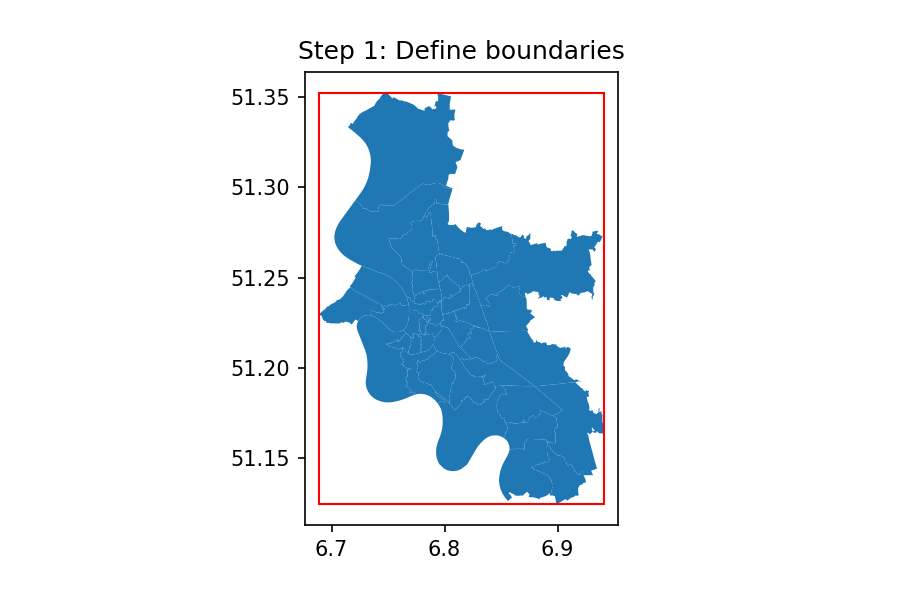

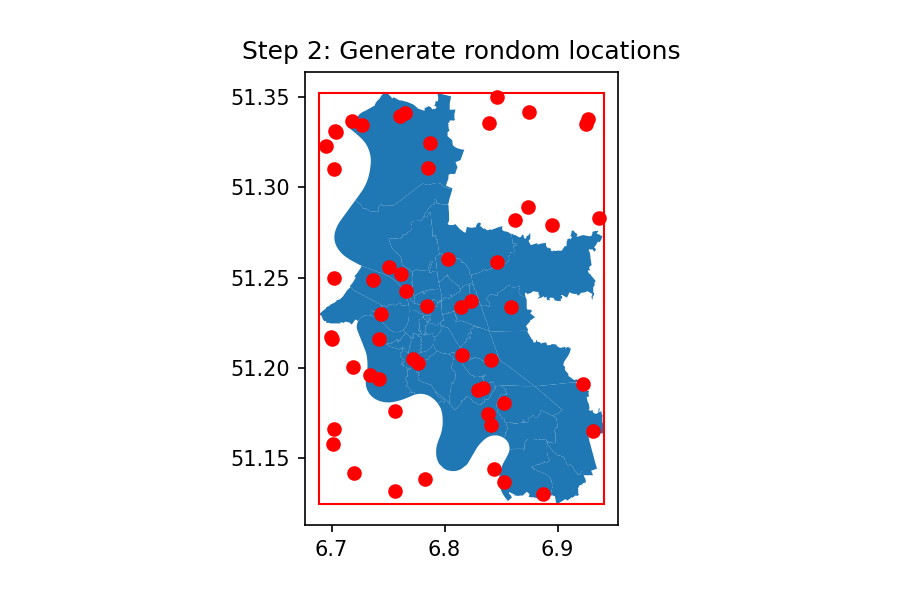
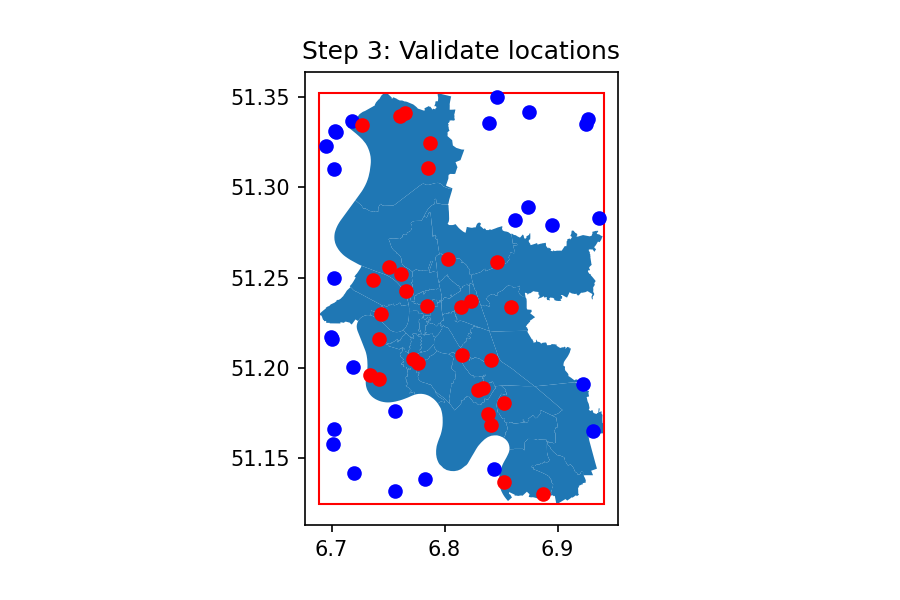

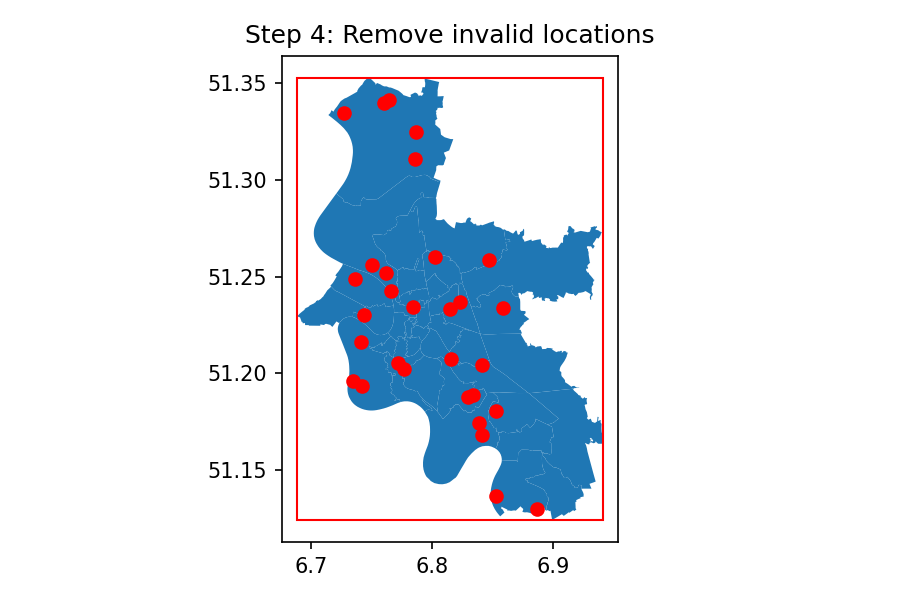

In [ ]:
from shapely.geometry import Point, Polygon
def randomize_location(num_pt, polygon):
    """
    Generate num_pt random location coordinates .
    :param num_pt INT number of random location coordinates
    :param polygon geopandas.geoseries.GeoSeries the polygon of the region
    :return x, y lists of location coordinates, longetude and latitude
    """
    # define boundaries
    minx, miny, maxx, maxy = polygon.bounds

    i = 0
    x = []
    y = []
    while i < num_pt:
        # generate random location coordinates
        x_t = np.random.uniform(minx, maxx)
        y_t = np.random.uniform(miny, maxy)
        # further check whether it is in the city area 
        if Point(x_t, y_t).within(polygon):
            x.append(x_t)
            y.append(y_t)
            i = i + 1

    return gpd.GeoSeries(gpd.points_from_xy(x, y), crs="EPSG:4326")



For instance, we would try to get 30 random point in the a block in a given block: 

In [ ]:
countydf = getSFDF("17031837100")
newBlock  = countydf.iloc[10]
newBlock

STATEFP                                                    17
COUNTYFP                                                  031
TRACTCE                                                837100
BLOCKCE                                                  2012
GEOID                                         170318371002012
NAME                                               Block 2012
MTFCC                                                   G5040
UR                                                          R
UACE                                                     None
UATYPE                                                   None
FUNCSTAT                                                    S
ALAND                                                    9372
AWATER                                                      0
INTPTLAT                                          +41.8846495
INTPTLON                                         -087.6980669
geometry    POLYGON ((-87.698847 41.884724, -87.697941 41....
Name: 13

In [ ]:
import matplotlib.patches as patches

boundary = newBlock["geometry"]
nameBlock = newBlock["NAME"]
random_points = randomize_location(30, boundary)
random_points.explore()

In [ ]:
newBlockDecennialData = BlockByFIPS("170318371002012")
sample = newBlockDecennialData.getSample(30)
sample

[<Person block_FIPS:170318371002012, race:P1_006N>,
 <Person block_FIPS:170318371002012, race:P1_011N>,
 <Person block_FIPS:170318371002012, race:P1_011N>,
 <Person block_FIPS:170318371002012, race:P1_003N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_003N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_003N>,
 <Person block_FIPS:170318371002012, race:P1_011N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_003N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_003N>,
 <Person block_FIPS:170318371002012, race:P1_006N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_004N>,
 <Person block_FIPS:170318371002012, race:P1_003N>,
 <Person block_FIPS:170318371002012, race:P1_019N>,
 <Person blo

In [ ]:
locations = gpd.GeoDataFrame(data={"Person Race": list(map(lambda x: x.race,sample)), "geometry":random_points}, crs="EPSG:4326")
locations

,Person Race,geometry
0,P1_006N,POINT (-87.69881 41.88455)
1,P1_011N,POINT (-87.69834 41.88424)
2,P1_011N,POINT (-87.69766 41.88472)
3,P1_003N,POINT (-87.69837 41.88439)
4,P1_004N,POINT (-87.69777 41.88463)
5,P1_003N,POINT (-87.69779 41.88438)
6,P1_004N,POINT (-87.69845 41.88457)
7,P1_003N,POINT (-87.69850 41.88460)
8,P1_011N,POINT (-87.69806 41.88467)
9,P1_004N,POINT (-87.69861 41.88437)


In [ ]:
locations.explore("Person Race")

## Plotting in interaction map

### Installing module folium

In [ ]:
!pip install folium geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 6.3 MB 25.2 MB/s 
     |████████████████████████████████| 16.7 MB 291 kB/s 


In [ ]:
# Import the folium library
import folium
from shapely.geometry import Polygon, Point
import geopandas as gpd

# Build the default map for a specific location
def add_points_to_map(lst_points, name =None, m = None):
    if (m is None):
        # get the center of all the points
        P = Polygon(lst_points)
        centroid = P.centroid
        print(centroid)

        # create the maps with center is the centroid of every points
        m = folium.Map(location=[centroid.y, centroid.x], zoom_start=100)

    # mark all the points
    for point in lst_points:
        folium.Marker(location=[point.y, point.x]).add_to(m)
    return m

def add_border_to_map(border_polygon, name = None, m = None):
    if (m is None):
        m = folium.Map(location=[border_polygon.centroid.y, border_polygon.centroid.x], zoom_start=10)

    sim_geo = border_polygon
    geo_j = gpd.GeoSeries([sim_geo]).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    if name is not None:
        folium.Popup(name).add_to(geo_j)
    geo_j.add_to(m)

    return m

In [ ]:
x, y = randomize_location(30, boundary)
lst_points = [Point(x[i], y[i]) for i in range(len(x))]

print(lst_points)
m = add_points_to_map(lst_points)
m

[<shapely.geometry.point.Point object at 0x7f41b1d14390>, <shapely.geometry.point.Point object at 0x7f41b1d14d90>, <shapely.geometry.point.Point object at 0x7f41b1d14f10>, <shapely.geometry.point.Point object at 0x7f41b1d14c50>, <shapely.geometry.point.Point object at 0x7f41b1d14cd0>, <shapely.geometry.point.Point object at 0x7f41cdde77d0>, <shapely.geometry.point.Point object at 0x7f41cdde76d0>, <shapely.geometry.point.Point object at 0x7f41cdde7e90>, <shapely.geometry.point.Point object at 0x7f41daf977d0>, <shapely.geometry.point.Point object at 0x7f41b1d14210>, <shapely.geometry.point.Point object at 0x7f41daf97dd0>, <shapely.geometry.point.Point object at 0x7f41daf97590>, <shapely.geometry.point.Point object at 0x7f41daf97ad0>, <shapely.geometry.point.Point object at 0x7f41daf97390>, <shapely.geometry.point.Point object at 0x7f42059ed050>, <shapely.geometry.point.Point object at 0x7f42059ed090>, <shapely.geometry.point.Point object at 0x7f42059ed110>, <shapely.geometry.point.Point 

In [ ]:
m = add_border_to_map(boundary, name = nameBlock, m = m)
m

## Highlight with id

In [ ]:
def plot_map_fill_multiples_ids(title, city, sf, 
                                               x_lim = None, 
                                               y_lim = None, 
                                               figsize = (11,9), 
                                               color = 'r'):
  
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in city:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

## Reference
Bureau, U. S. C. (2022, March 10). *Decennial Census (2020, 2010, 2000)*. Census.gov. Retrieved July 14, 2022, from https://www.census.gov/data/developers/data-sets/decennial-census.html 

https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac